# Wstępna obróbka

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
dane = pd.read_csv('cervical-cancer_csv.csv')

# usuwanie kolumn
dane = dane.drop(['STDs:cervical condylomatosis', 
         'STDs:vaginal condylomatosis', 
         'STDs:pelvic inflammatory disease', 
         'STDs:genital herpes',
         'STDs:molluscum contagiosum',
         'STDs:AIDS',
         'STDs:Hepatitis B',
         'STDs:HPV', 'Dx:CIN'], axis=1)

# uzupełnianie braków i kodowanie zmiennych kategorycznych
def column_nodata(df, column_name):
    df[column_name + "_null"] = df[column_name].apply(lambda x: 1 if pd.isnull(x) else 0)
    df[column_name] = df[column_name].fillna(0)

def replace_in_column(df, column_name, src, dst):
    df[column_name] = df[column_name].replace(to_replace=src, value=dst)

replace_in_column(dane, 'STDs (number)', [3, 4], 2)
replace_in_column(dane, 'STDs: Number of diagnosis', [2,3], 1)

nodata_categories = [
    'Smokes',
    'Hormonal Contraceptives',
    'IUD',
    'STDs',
    'STDs (number)',
    'STDs:condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:HIV'
]

for category in nodata_categories:
    column_nodata(dane, category)
    
dane = pd.concat([dane, pd.get_dummies(dane['STDs (number)'], prefix='STDs_')],axis=1)
dane.drop(['STDs (number)'],axis=1, inplace=True)

# standaryzacja
numerical = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 
            'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs: Time since first diagnosis',
            'STDs: Time since last diagnosis']

scaler = StandardScaler() 
dane_scaled = scaler.fit_transform(dane[numerical])
d2 = pd.DataFrame(dane_scaled, columns = numerical)
dane[numerical] = d2[numerical]

# stworzenie jednego targetu
targets = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']
def has_cancer(row):
    for target in targets:
        if row[target] == 1:
            return 1
    return 0

dane['cancer'] = dane.apply(lambda row: has_cancer(row), axis=1)
dane = dane.drop(targets, axis=1)

# Ujednolicone funkcje dla wszystkich modeli

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# podzial zbioru na treningowy i testowy
def default_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=2137)

# scoring
def scoring(y_test, y_predicted):
    print("ACC = ", accuracy_score(y_test, y_predicted))
    print("PREC = ", precision_score(y_test, y_predicted))
    print("RECALL = ", recall_score(y_test, y_predicted))
    print("F1 = ", f1_score(y_test, y_predicted))
    print("FPR = ", roc_auc_score(y_test, y_predicted))

# wyodrebnienie y
def extract_y(data):
    y = data[["cancer"]]
    return data.drop(["cancer"], axis=1), y

# Las losowy

In [3]:
# przygotowanie danych
X, y = extract_y(dane)
X = X.fillna(0)

X_train, X_test, y_train, y_test = default_split(X, y)
print(X.shape, X_train.shape, X_test.shape)

(835, 34) (668, 34) (167, 34)


In [37]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=50,
                                  max_depth=100,
                                  min_samples_split = 2,
                                  max_features = 7,
                                  random_state=0,
                                  n_jobs = -1)
model_rf.fit(X_train, y_train)
y_predicted_old = model_rf.predict(X_test)
scoring(y_test, y_predicted_old)

ACC =  0.8622754491017964
PREC =  0.5
RECALL =  0.08695652173913043
F1 =  0.14814814814814817
FPR =  0.5365338164251208


In [13]:
y_test['cancer'].to_numpy()

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=int64)

In [108]:
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Jak widać, las losowy skutecznie mówi dwójce pacjentek bez raka, że go mają, a 26 chorym pacjentkom, że są jednak zdrowe. Udaje mu się poprawnie przypisać raka jednej osobie.
O score może lepiej po prostu nic nie mówić.

In [110]:
y_test['cancer'].value_counts()

0    140
1     27
Name: cancer, dtype: int64

# BogoModel

In [21]:
prob = y_train['cancer'].value_counts()[1]/y_train['cancer'].value_counts()[0]
prob

0.13220338983050847

In [22]:
import copy
def randomly_predict(prob):
    y_random_predicted = copy.copy(y_test)
    y_random_predicted['cancer'] = np.random.choice([0, 1], len(y_test), p=[1-prob, prob])
    return y_random_predicted

scoring(y_test, randomly_predict(prob))

ACC =  0.8083832335329342
PREC =  0.2857142857142857
RECALL =  0.2608695652173913
F1 =  0.2727272727272727
FPR =  0.5783514492753624


# Porównanie

In [118]:
random_scores_acc = []
random_scores_prec = []
random_scores_recall = []
random_scores_f1 = []
random_scores_auc = []
for i in range(30):
    y_random_predicted = randomly_predict(prob)
    random_scores_acc.append(accuracy_score(y_test, y_random_predicted))
    random_scores_prec.append(precision_score(y_test, y_random_predicted))
    random_scores_recall.append(recall_score(y_test, y_random_predicted))
    random_scores_f1.append(f1_score(y_test, y_random_predicted))
    random_scores_auc.append(roc_auc_score(y_test, y_random_predicted))
    
rf_score_acc = [accuracy_score(y_test, y_predicted)] * 30
rf_score_prec = [precision_score(y_test, y_predicted)] * 30
rf_score_recall = [recall_score(y_test, y_predicted)] * 30
rf_score_f1 = [f1_score(y_test, y_predicted)] * 30
rf_auc_score = [roc_auc_score(y_test, y_predicted)] * 30

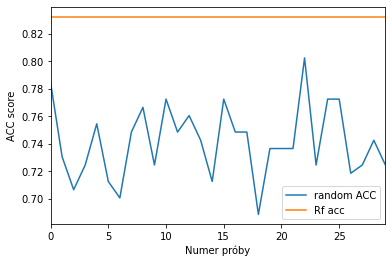

In [112]:
df = pd.DataFrame(list(zip(random_scores_acc, rf_score_acc)), 
               columns =['random ACC', 'Rf acc'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("ACC score")
plot

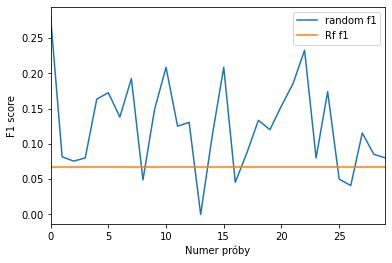

In [113]:
df = pd.DataFrame(list(zip(random_scores_f1, rf_score_f1)), 
               columns =['random f1', 'Rf f1'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("F1 score")
plot

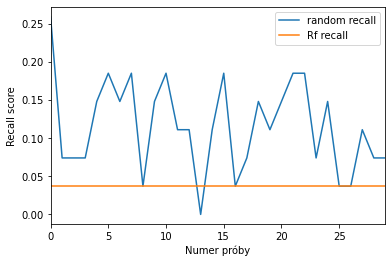

In [114]:
df = pd.DataFrame(list(zip(random_scores_recall, rf_score_recall)), 
               columns =['random recall', 'Rf recall'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("Recall score")
plot

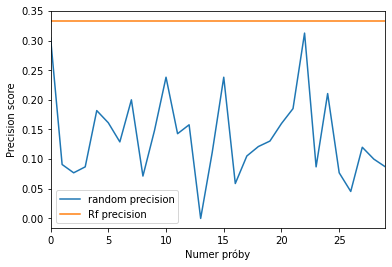

In [115]:
df = pd.DataFrame(list(zip(random_scores_prec, rf_score_prec)), 
               columns =['random precision', 'Rf precision'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("Precision score")
plot

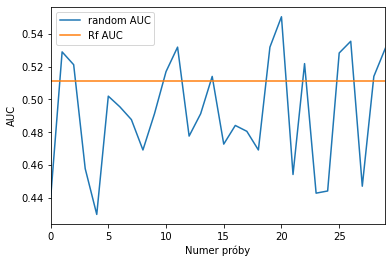

In [119]:
df = pd.DataFrame(list(zip(random_scores_auc, rf_auc_score)), 
               columns =['random AUC', 'Rf AUC'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("AUC")
plot

# Strojenie

In [45]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500, 800]
max_depth = [10, 25, 50, 75, 100]
min_samples_split = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 5] 
forest = RandomForestClassifier(random_state = 0)
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, 
                      n_jobs = -1, scoring = 'recall')
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.1min finished


In [46]:
bestF

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

Generalnie po drodze było umiarkowanie śmiesznie, bo jak robiło się to dla samego accuracy, to wrzucał chyba wszystkim zera XD Super model
Wcześniej było rozważane to samo, z nieco innymi parametrami, szczególnie `random_state=1`, ale 

In [47]:
y_predicted_new = bestF.predict(X_test)
scoring(y_test, y_predicted_new)

ACC =  0.8622754491017964
PREC =  0.5
RECALL =  0.043478260869565216
F1 =  0.08
FPR =  0.5182669082125604


<module 'matplotlib.pyplot' from 'C:\\Users\\finwe\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

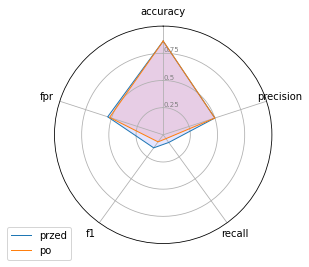

In [48]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['przed','po'],
'accuracy': [accuracy_score(y_test, y_predicted_old), accuracy_score(y_test, y_predicted_new)],
'precision': [precision_score(y_test, y_predicted_old), precision_score(y_test, y_predicted_new)],
'recall': [recall_score(y_test, y_predicted_old), recall_score(y_test, y_predicted_new)],
'f1': [f1_score(y_test, y_predicted_old), f1_score(y_test, y_predicted_new)],
'fpr': [roc_auc_score(y_test, y_predicted_old), roc_auc_score(y_test, y_predicted_new)]
})
 
 
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="grey", size=7)
plt.ylim(0,1)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="przed")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="po")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt

In [49]:
df

,group,accuracy,precision,recall,f1,fpr
0,przed,0.862275,0.5,0.086957,0.148148,0.536534
1,po,0.862275,0.5,0.043478,0.080000,0.518267
